This notebooks uses the dataset from 'Persistent Homology for the Quantitative Evaluation of Architectural Features in Prostate Cancer Histology' by Lawson et al.   
https://doi.org/10.1038/s41598-018-36798-y

Download the original dataset from https://osf.io/k96qw  

Alternatively, precomputed ECCs and ECPs can be found as pickle files at  
https://drive.google.com/drive/folders/1Nn93YWzY0ErW__KhVjmYulxConODOoYP?usp=sharing

In [ ]:
! pip install histomicstk --find-links https://girder.github.io/large_image_wheels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageOps

from tqdm.notebook import tqdm

In [ ]:
# Load labels
labels = pd.read_csv('osfstorage-archive/rois-with-grade.csv')
labels

,roi_label,grade
0,1_1,3
1,1_2,3
2,1_3,3
3,1_4,3
4,1_5,3
...,...,...
5177,15_270,3
5178,15_271,3
5179,15_272,3
5180,15_273,3


In [ ]:
# Load and preprocess the images
# https://digitalslidearchive.github.io/HistomicsTK/examples/color_normalization_and_augmentation.html
import histomicstk as htk

# color norm. standard (from TCGA-A2-A3XS-DX1, Amgad et al, 2019)
cnorm = {
    'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
    'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),
}

# https://digitalslidearchive.github.io/HistomicsTK/examples/color_deconvolution.html
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

processed_data = []

for i, row in tqdm(labels.iterrows()):
    temp = Image.open('/content/drive/MyDrive/osfstorage-archive/rois/{}.tiff'.format(row.roi_label))
    tissue_rgb = np.array(temp)
    tissue_rgb_normalized = htk.preprocessing.color_normalization.reinhard(tissue_rgb, 
                                                                           target_mu=cnorm['mu'], 
                                                                           target_sigma=cnorm['sigma'])
    
    # perform standard color deconvolution
    imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(tissue_rgb_normalized, W)

    # save img to 2d array
    processed_img = np.zeros(shape=(tissue_rgb.shape[0], tissue_rgb.shape[1], 2), 
                                    dtype=np.uint8)
    for i in 0, 1:
        processed_img[:, :, i] = imDeconvolved.Stains[:, :, i]

    # save np array and its grade
    processed_data.append([processed_img, row.grade])
    
    temp.close()

0it [00:00, ?it/s]

In [ ]:
# dump to pickle
import pickle

with open('pkls/processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

# compute ECP

In [ ]:
import numpy as np

# load pickle
import pickle

with open('pkls/processed_data.pkl','rb') as f:
    processed_data = pickle.load(f)

In [ ]:
from src.RGBcubical_utils import compute_RGB_contributions

from tqdm.notebook import tqdm

chunks = 100

for i in range(0, 5100, chunks):
    print(i, i+chunks)
    ECP = []
    for img, label in tqdm(processed_data[i:i+chunks]):
        ECP.append([compute_RGB_contributions(img.astype(np.uint16)), label])
    
    with open('pkls/ECP_{}_{}.pkl'.format(i, i+chunks), 
              'wb') as f:
        pickle.dump(ECP, f)
    
    del ECP

# Subsample ECP

In [ ]:
import numpy as np
import pickle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [ ]:
with open('pkls/processed_data.pkl','rb') as f:
    data = pickle.load(f)

In [ ]:
from src.RGBcubical_utils import compute_RGB_contributions

In [ ]:
ECP = []

R = 8 # rescale factor

for img, label in tqdm(data):
    ECP.append([compute_RGB_contributions((img // R * R).astype(np.uint16)), label])

with open('pkls/ECP_32.pkl', 'wb') as f:
    pickle.dump(ECP, f)

  0%|          | 0/5182 [00:00<?, ?it/s]

In [ ]:
with open('pkls/ECP_32.pkl', 'rb') as f:
    ECP = pickle.load(f)

In [ ]:
ECP_images = []

for profile, label in tqdm(ECP):
    img = np.zeros((32,32))
    for c in profile:
        img[c[0][0] // 8:, c[0][1] // 8:] += c[1]
    ECP_images.append([img, label])

  0%|          | 0/5182 [00:00<?, ?it/s]

ECP
(5182, 1024)
(5182,)
(2567, 1024) (2351, 1024) (264, 1024)
SVM NO RESAMPLE
grade3 vs grade4


  0%|          | 0/100 [00:00<?, ?it/s]

svm accuracy: 0.8265548780487805


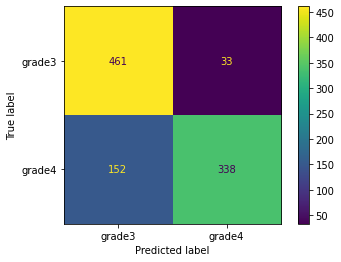

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('ECP')
X = np.array([ecp.reshape(-1) for ecp, label in ECP_images])
y = np.array([label for ecc, label in ECP_images])

print(X.shape)
print(y.shape)

# Create holder arrays to load in landscapes of each cell type
grade3 = X[y == 3]
grade4 = X[y == 4]
grade5 = X[y == 5]

print(grade3.shape, grade4.shape, grade5.shape)

print('SVM NO RESAMPLE')

test_split = 0.2
nbr_of_repeats = 100


for X, y, label in zip(
    [
        np.vstack([grade3, grade4]),
        # np.vstack([grade5, grade4]),
        # np.vstack([grade5, grade3]),
        # np.vstack([grade5, grade4, grade3]),
    ],
    [
        np.array(["grade3"] * len(grade3) + ["grade4"] * len(grade4)),
        # np.array(["grade5"] * len(grade5) + ["grade4"] * len(grade4)),
        # np.array(["grade5"] * len(grade5) + ["grade3"] * len(grade3)),
        # np.array(["grade5"] * len(grade5) + ["grade4"] * len(grade4) + ["grade3"] * len(grade3)),
    ],
    ["grade3 vs grade4", 
    #  "grade4 vs grade5", "grade3 vs grade5", "3way",
    ],
):

    print(label)
    test_accuracy_SVM = []
    
    for i in tqdm(range(nbr_of_repeats)):
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_split, random_state=i)
        
        
        SVM_classifier = svm.SVC(kernel='rbf', 
                                class_weight='balanced', 
                                C=1,
                                random_state=42)
        SVM_classifier.fit(X_train, y_train)
        test_accuracy_SVM.append(SVM_classifier.score(X_test, y_test))


    print("svm accuracy:", np.mean(test_accuracy_SVM))
    
    predictions = SVM_classifier.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=SVM_classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=SVM_classifier.classes_)
    disp.plot()

    plt.show()

In [ ]:
np.std(test_accuracy_SVM) / 10

0.0011585414883650352

LDA NO RESAMPLE
ECP
(5182, 1024)
(5182,)
(2567, 1024) (2351, 1024) (264, 1024)
SVM NO RESAMPLE
grade3 vs grade4


  0%|          | 0/100 [00:00<?, ?it/s]

lda accuracy: 0.8120528455284552


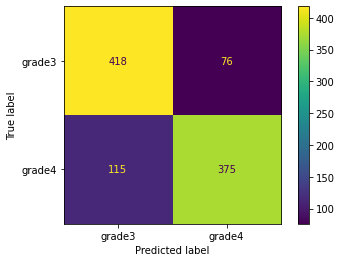

In [ ]:
print('LDA NO RESAMPLE')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('ECP')
X = np.array([ecp.reshape(-1) for ecp, label in ECP_images])
y = np.array([label for ecc, label in ECP_images])

print(X.shape)
print(y.shape)

# Create holder arrays to load in landscapes of each cell type
grade3 = X[y == 3]
grade4 = X[y == 4]
grade5 = X[y == 5]

print(grade3.shape, grade4.shape, grade5.shape)

print('SVM NO RESAMPLE')

test_split = 0.2
nbr_of_repeats = 100


for X, y, label in zip(
    [
        np.vstack([grade3, grade4]),
        # np.vstack([grade5, grade4]),
        # np.vstack([grade5, grade3]),
        # np.vstack([grade5, grade4, grade3]),
    ],
    [
        np.array(["grade3"] * len(grade3) + ["grade4"] * len(grade4)),
        # np.array(["grade5"] * len(grade5) + ["grade4"] * len(grade4)),
        # np.array(["grade5"] * len(grade5) + ["grade3"] * len(grade3)),
        # np.array(["grade5"] * len(grade5) + ["grade4"] * len(grade4) + ["grade3"] * len(grade3)),
    ],
    ["grade3 vs grade4", 
    #  "grade4 vs grade5", "grade3 vs grade5", "3way",
    ],
):

    print(label)
    test_accuracy_lda = []
    
    for i in tqdm(range(nbr_of_repeats)):
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_split, random_state=i)
        
        
        ldr_classifier = LinearDiscriminantAnalysis()
        ldr_classifier.fit(X_train, y_train)
        test_accuracy_lda.append(ldr_classifier.score(X_test, y_test))


    print("lda accuracy:", np.mean(test_accuracy_lda))
    
    predictions = ldr_classifier.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=ldr_classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=ldr_classifier.classes_)
    disp.plot()

    plt.show()